In [1]:
# Script for training a denoiser
import os

os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/gpfslocalsys/cuda/11.1.0'

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import haiku as hk
import jax
import optax
import jax.numpy as jnp
import numpy as onp
import pickle
from functools import partial

import tensorflow as tf
import tensorflow_datasets as tfds

from jax_lensing.inversion import ks93inv, ks93

from jax_lensing.spectral import measure_power_spectrum, make_power_map

from astropy.io import fits

from tqdm.notebook import tqdm

In [4]:
resolution = 0.29
pixel_size = jnp.pi * resolution / 180. / 60. #rad/pixel
map_size = 360
gaussian_path = "../../data/ktng/ktng_PS_theory.npy"
sigma_gamma = .148

ps_data = onp.load(gaussian_path).astype('float32')
ell = jnp.array(ps_data[0,:])
ps_halofit = jnp.array(ps_data[1,:] / pixel_size**2) # normalisation by pixel size
kell = ell /2/jnp.pi * 360 * pixel_size / map_size
# Interpolate the Power Spectrum in Fourier Space
ps_map = jnp.array(make_power_map(ps_halofit, map_size, kps=kell))

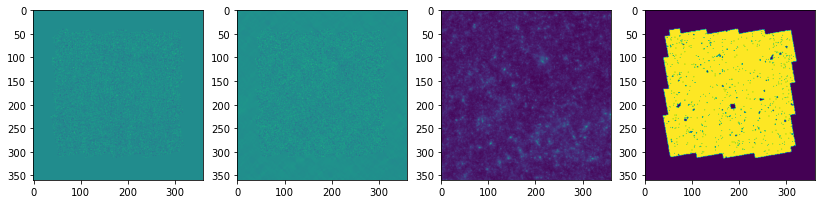

In [5]:
mask = fits.getdata('../../data/COSMOS/cosmos_full_mask_0.29arcmin360copy.fits').astype('float32')

convergence = fits.getdata('../../data/ktng/ktng_kappa360v2.fits').astype('float32')
meas_shear = jnp.stack(ks93inv(convergence, jnp.zeros_like(convergence)), axis=-1)
std1 = fits.getdata('../../data/COSMOS/std1.fits').astype('float32').reshape((360,360,1))
std2 = fits.getdata('../../data/COSMOS/std2.fits').astype('float32').reshape((360,360,1))
sigma_gamma = jnp.concatenate([std1, std2], axis=-1)
meas_shear += sigma_gamma * jax.random.normal(jax.random.PRNGKey(0), meas_shear.shape)
#meas_shear += 0.148*np.random.randn(360,360,2)

mask = jnp.expand_dims(mask, -1)
sigma_mask = (1-mask)*10**3

masked_true_shear = meas_shear*mask

figure(figsize(14,5))
subplot(141)
imshow(masked_true_shear[..., 0])
subplot(142)
imshow(meas_shear[..., 1])
subplot(143)
imshow(convergence)
subplot(144)
imshow(mask[...,0])

In [6]:
def log_gaussian_prior(map_data, sigma, ps_map):
    map_data = map_data.reshape(360, 360)
    data_ft = jnp.fft.fft2(map_data) / float(map_size)
    return -0.5*jnp.sum(jnp.real(data_ft*jnp.conj(data_ft)) / (ps_map+sigma**2))

gaussian_prior_score = jax.vmap(jax.grad(log_gaussian_prior), in_axes=[0,0, None])

In [7]:
def log_likelihood(x, sigma, meas_shear, mask):
    """ Likelihood function at the level of the measured shear
    """
    ke = x.reshape((map_size, map_size))
    kb = jnp.zeros(ke.shape)
    model_shear = jnp.stack(ks93inv(ke, kb), axis=-1)
    return - jnp.sum((model_shear - masked_true_shear)**2/((sigma_gamma)**2 + sigma**2 + sigma_mask) )/2.

    #return - jnp.sum(mask*(model_shear - meas_shear)**2/((sigma_gamma)**2 + sigma**2) )/2.

likelihood_score = jax.vmap(jax.grad(log_likelihood), in_axes=[0,0, None, None])

In [8]:
def total_score_fn(x, sigma):
    """ Compute the total score, combining the following components:
        gaussian prior, ml prior, data likelihood
    """
    data_score = likelihood_score(x, sigma, meas_shear, mask)
    gaussian_score = gaussian_prior_score(x, sigma, ps_map)
    return (data_score + gaussian_score).reshape(-1, 360*360)

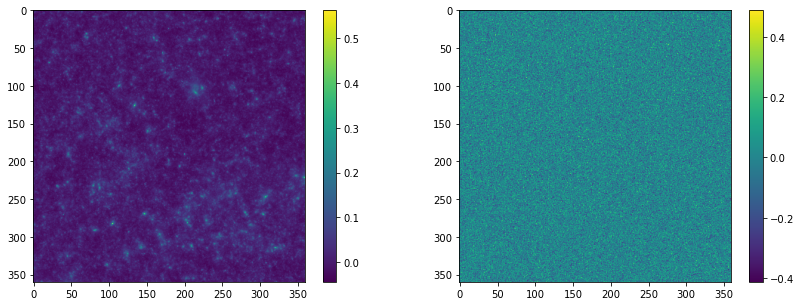

In [9]:
import numpy as onp
kappa_init = onp.random.randn(map_size, map_size) * 0.1
sigma = jnp.zeros((1,1,1))

# Initialize with KS93
subplot(121)
imshow(convergence)
colorbar()
subplot(122)
imshow(kappa_init)
colorbar()

kappa_init = jnp.expand_dims(kappa_init, axis=0)

In [10]:
# compute MAP update
eps = 1e-5

@jax.jit
def update(x_old):
    gradient = total_score_fn(x_old, sigma)
    print(gradient)
    x_new = x_old + eps * gradient.reshape(1, 360, 360)
    return x_new

In [11]:
x_old = kappa_init.copy()
loss = []
samples = []

n_steps = 20000

for i in tqdm(range(n_steps)):
    x_new = update(x_old)
    samples.append(x_new)
    x_old = x_new
    
convergence_MAP = x_new[0,...]

  0%|          | 0/20000 [00:00<?, ?it/s]

Traced<ShapedArray(float32[1,129600])>with<DynamicJaxprTrace(level=0/1)>


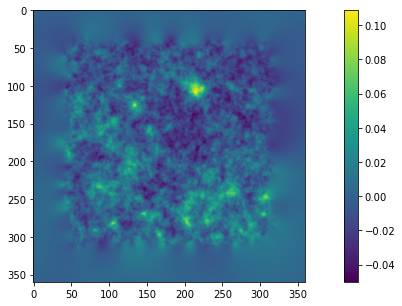

In [12]:
imshow(convergence_MAP)
colorbar()

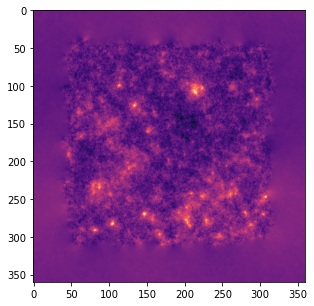

In [15]:
root = 'res/wiener_samples'
ode = jnp.load(root+str(1)+'.npy')
for i in range(2,11):
    if i!=3:
        ode = jnp.concatenate([ode, jnp.load(root+str(i)+'.npy')])
    
ode_wiener = ode.mean(axis=0)
imshow(ode_wiener, cmap='magma', vmin=-0.05, vmax=0.1)

## Wiener Solution
Messenger Field algorithm

In [16]:
import jax.numpy as jnp
import numpy as np 
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import gc
import jax, sys
import importlib
from jax.ops import index, index_add, index_update

In [17]:
from jax_lensing import wiener_sampling, spectral, inversion

In [18]:
from astropy.io import fits
from jax_lensing.inversion import ks93inv

In [19]:
mask = mask[...,0]

In [20]:
test_kappa = convergence
test_e = meas_shear
ps_ktng_th = jnp.load("../../data/ktng/ktng_PS_theory.npy").astype('float32')

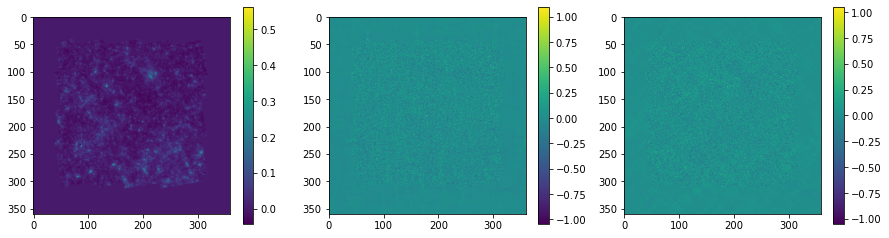

In [21]:
_ = plt.figure(figsize=(15,4))
_ = plt.subplot(131), plt.imshow(test_kappa*mask), plt.colorbar()
_ = plt.subplot(132), plt.imshow(test_e[:,:,0]), plt.colorbar()
_ = plt.subplot(133), plt.imshow(test_e[:,:,1]), plt.colorbar()

In [50]:
std_e1 = 0.148
#ncov_diag_e1 = np.ones(test_kappa.shape)*std_e1*std_e1*mask + np.abs(1.-mask)*1e10
#ncov_diag_e2 = np.ones(test_kappa.shape)*std_e1*std_e1*mask + np.abs(1.-mask)*1e10
ncov_diag_e1 = np.ones(test_kappa.shape)*std1[...,0]*std1[...,0]*mask + np.abs(1.-mask)*1e10
ncov_diag_e2 = np.ones(test_kappa.shape)*std1[...,0]*std1[...,0]*mask + np.abs(1.-mask)*1e10

In [51]:
resolution = 0.29 # arcmin/pixel
pixel_size = jnp.pi * resolution / 180. / 60. #rad/pixel

In [52]:
k_map, ps_map = spectral.measure_power_spectrum(test_kappa+1j*test_kappa*0., pixel_size)
k_map = index_update(k_map, index[0], 0.)
ps_map = index_update(ps_map, index[128:], 0.)

k_map = k_map / 2 / jnp.pi * pixel_size * 360
ps_map = ps_map / pixel_size**2

In [53]:
kell = ps_ktng_th[0,:] / 2 / jnp.pi * pixel_size * 360
ps_th = ps_ktng_th[1,:] / pixel_size**2

k = np.arange(k_map.shape[0])
ps_th_interp = jnp.interp(k, kell, ps_th)
ps_th_interp = index_update(ps_th_interp, index[0], 0.)
ps_th_interp = index_update(ps_th_interp, index[128:], 0.)

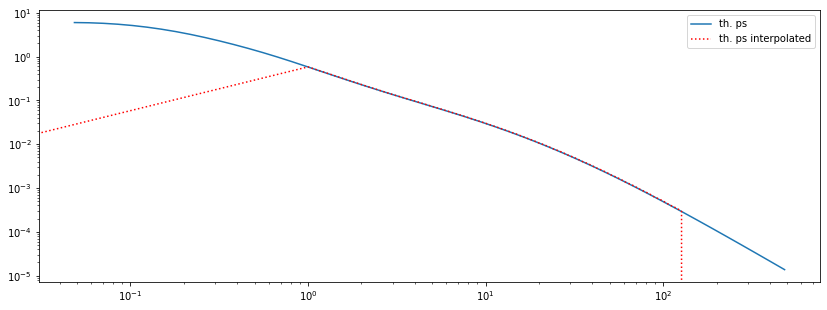

In [54]:
#plt.loglog(k_map, ps_map, '--', label='ps from map')
plt.loglog(kell, ps_th, label='th. ps')
plt.loglog(ps_th_interp, ':', color='red', label='th. ps interpolated')
plt.legend()

In [55]:
ps_th_map = jnp.fft.fftshift(spectral.make_power_map(ps_th_interp,360))
ps_th_map = index_update(ps_th_map, index[180,180], 0.)

In [56]:
# Use the thoertical Power Spectrum
ps_map = ps_th_map

In [57]:
%%time
wf_e1, wf_e2 = wiener_sampling.spin_wiener_filter_jit(test_e[:,:,0]+1j*test_kappa*0.,
                                                      test_e[:,:,1]+1j*test_kappa*0.,
                                                      ncov_diag_e1,
                                                      ncov_diag_e2,
                                                      ps_map,
                                                      ps_map*0.,
                                                      iterations=20)
wf_e, wf_b = inversion.ks93(wf_e1, wf_e2)

CPU times: user 28.5 ms, sys: 5.5 ms, total: 34 ms
Wall time: 26.7 ms


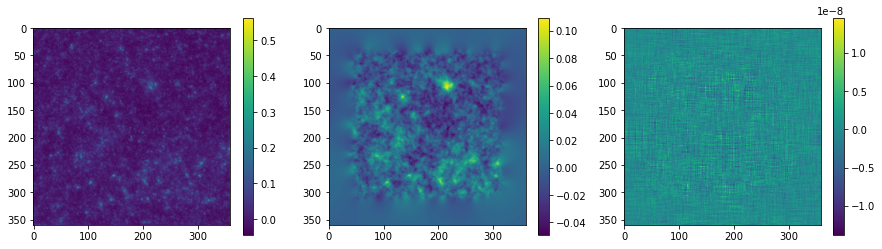

In [58]:
_ = plt.figure(figsize=(15,4))
_ = plt.subplot(131), plt.imshow(test_kappa), plt.colorbar()
_ = plt.subplot(132), plt.imshow(wf_e), plt.colorbar()
_ = plt.subplot(133), plt.imshow(wf_b), plt.colorbar()

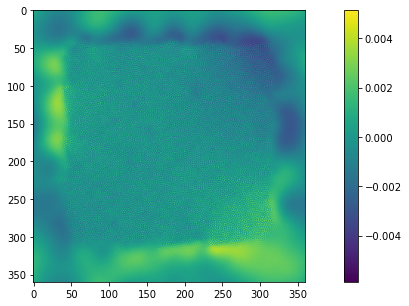

In [59]:
imshow(convergence_MAP-wf_e)
colorbar()

In [60]:
resolution = 0.29 # arcmin/pixel
pixel_size = np.pi * resolution / 180. / 60. #rad/pixel

nsm_map = convergence_MAP
kp = convergence

k_wiener, ps_wiener = spectral.measure_power_spectrum(wf_e, pixel_size)
k_nsm_map, ps_nsm_map = spectral.measure_power_spectrum(nsm_map, pixel_size)
k_map, ps_map = spectral.measure_power_spectrum(kp, pixel_size)
k_mean, ps_mean = spectral.measure_power_spectrum(ode.mean(axis=0), pixel_size)
#k_nsm_mean, ps_nsm_mean = spectral.measure_power_spectrum(nsm_mean, pixel_size)

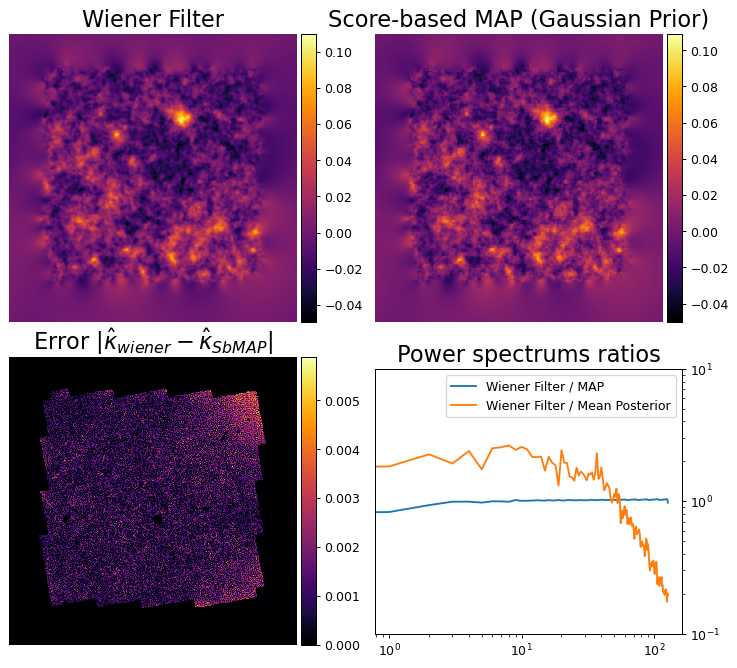

In [61]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

kwargs = dict(cmap='inferno')
fontsize=dict(fontsize=18)

#_ = plt.figure(figsize=(10,10))
fig, ax = plt.subplots(2,2, figsize=(8,8), dpi=90)

im = ax[0,0].imshow(wf_e, **kwargs)
ax[0,0].set_title('Wiener Filter', **fontsize)
ax[0,0].axis('off')#, colorbar()
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

im = ax[0,1].imshow(nsm_map, interpolation='None', **kwargs)
ax[0,1].set_title('Score-based MAP (Gaussian Prior)', **fontsize)
ax[0,1].axis('off')#,  plt.colorbar()
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

im = ax[1,0].imshow(mask*np.abs(wf_e - nsm_map), interpolation='None', **kwargs)
ax[1,0].set_title(r'Error $\|\hat{\kappa}_{wiener}-\hat{\kappa}_{SbMAP}\|$', **fontsize)
ax[1,0].axis('off')#,  plt.colorbar()
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

ps_ratio = ps_wiener/ps_nsm_map
ps_ratio_mean = ps_wiener/ps_mean
ax[1,1].set_title('Power spectrums ratios', **fontsize)
ax[1,1].set_aspect('equal')
ax[1,1].loglog(ps_ratio[:128], label='Wiener Filter / MAP')
ax[1,1].loglog(ps_ratio_mean[:128], label='Wiener Filter / Mean Posterior')
#ax[1,1].loglog(ps_wiener/ps_nsm_mean, '--', label='Wiener Filter / Posterior Mean')
ax[1,1].set_ylim([1e-1, 1e1])
ax[1,1].legend()
ax[1,1].yaxis.tick_right()

plt.tight_layout(pad=0., w_pad=1., h_pad=-5.)

#plt.savefig('gaussian.pdf')

In [63]:
np.save('res/wf_e.npy', wf_e)

In [62]:
!ls res |grep wiener

wiener_cooling.npy
wiener_samples10.npy
wiener_samples11.npy
wiener_samples12.npy
wiener_samples13.npy
wiener_samples14.npy
wiener_samples15.npy
wiener_samples16.npy
wiener_samples17.npy
wiener_samples18.npy
wiener_samples19.npy
wiener_samples1.npy
wiener_samples20.npy
wiener_samples2.npy
wiener_samples4.npy
wiener_samples5.npy
wiener_samples6.npy
wiener_samples7.npy
wiener_samples8.npy
wiener_samples9.npy
wiener_solution.npy
